In [1]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape, LSTM, Conv2DTranspose
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageDraw
import os
from os.path import join
from IPython.display import clear_output
from tqdm.autonotebook import tqdm
import gc
import time
import json
import multiprocessing
gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental_run_functions_eagerly(True)
!wget https://big.galqiwi.ru/toshare/dataset.json

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


--2020-05-12 02:28:42--  https://big.galqiwi.ru/toshare/dataset.json
Resolving big.galqiwi.ru (big.galqiwi.ru)... 185.5.248.186
Connecting to big.galqiwi.ru (big.galqiwi.ru)|185.5.248.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152073197 (145M) [application/json]
Saving to: ‘dataset.json’

dataset.json        100%[===================>] 145.03M  9.79MB/s    in 16s     

2020-05-12 02:29:01 (8.84 MB/s) - ‘dataset.json’ saved [152073197/152073197]



In [0]:
loss = list(np.load('/content/gdrive/My Drive/midi-vae-4-lstm/lstm-2-dir/loss.npy'))

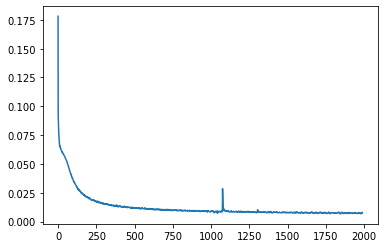

In [7]:
plt.plot(loss)

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#@title model matrix distribution
mean_value_dist = np.load('gdrive/My Drive/midi-vae-4-lstm/mean_value_dist.npy')
sigm_value_dist = np.load('gdrive/My Drive/midi-vae-4-lstm/sigm_value_dist.npy')

In [0]:
def encoded_to_norm(v):
  return (v - mean_value_dist) / sigm_value_dist / 4

def norm_to_encoded(v):
  return v * 4 * sigm_value_dist + mean_value_dist

In [10]:
#@title Model
decoder_model = load_model('gdrive/My Drive/midi-vae-4-lstm/decoder_4000-500_73845.h5')
encoder_model = load_model('gdrive/My Drive/midi-vae-4-lstm/encoder_4000-500_73845.h5')
latent_dim = 500
def model_reset():
  global model
  model = tf.keras.Sequential()
  model.add(Dense(latent_dim, activation='relu', input_shape=(None, latent_dim)))
  model.add(LSTM((1024), return_sequences = True))
  model.add(LSTM((1024), return_sequences = True))
  model.add(Dense(latent_dim, activation='tanh'))
model_reset()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, None, 500)         250500    
_________________________________________________________________
lstm (LSTM)                  (None, None, 1024)        6246400   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 1024)        8392704   
_________________________________________________________________
dense_1 (Dense)              (None, None, 500)         512500    
Total params: 15,402,104
Trainable params: 15,402,104
Non-trainable params: 0
_________________________________________________________________


In [0]:
def data_compressed_2_data(data_compressed, frame):
  for key in data_compressed:
    for press in data_compressed[key]:
      for _ in range(press[0], press[1]):
        frame[_][int(key)] = 1

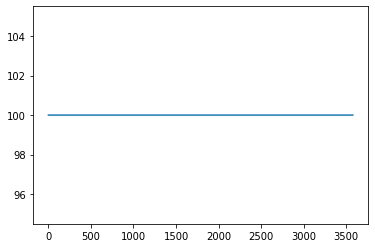

In [12]:
#@title init music_compressed
with open('dataset.json', 'r') as file:
  music_compressed_unfolded = json.load(file)
_ = []
music_compressed = []
for frame in music_compressed_unfolded:
  if frame is None:
    while len(_) >= 100:
      music_compressed.append(_[:100])
      _ = _[100:]
    _ = []
  else:
    _.append(frame)
music_compressed_test = music_compressed[-50:]
music_compressed = music_compressed[:-50]
plt.plot([len(_) for _ in music_compressed])
plt.show()

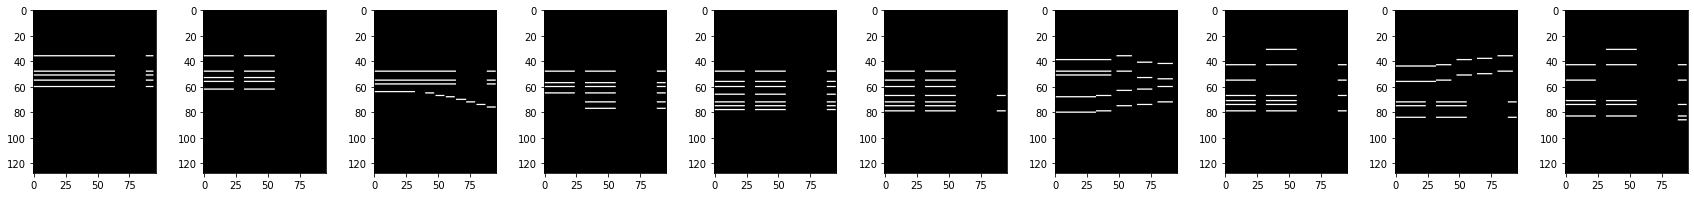

In [13]:
#@title test song
test_song = np.zeros((100, 96, 128))
for _ in range(100):
  data_compressed_2_data(music_compressed[-2][_], test_song[_])
plt.figure(figsize=(30, 3))
for _ in range(10):
  plt.subplot(1, 10, _ + 1)
  plt.imshow(test_song[_].T, cmap='gray')
plt.show()
test_song_encoded = encoded_to_norm(encoder_model(test_song).numpy()[:,:latent_dim])

In [14]:
#@title do not exec
max_value = min_value = 0
for _ in tqdm(range(len(music_compressed) // 100)):
  buffer = np.zeros((10000, 96, 128))
  for __ in range(100 * 100):
    data_compressed_2_data(music_compressed[_ * 100 + __ // 100][__ % 100], buffer[__])
  encoded_buffer = encoder_model(buffer).numpy()
  max_value = max(max_value, np.max(encoded_buffer))
  min_value = min(min_value, np.min(encoded_buffer))
buffer = None
encoded_buffer = None
gc.collect()
print(min_value, max_value)


-15.915852 8.847335


In [0]:
music_encoded_list = []
for _ in tqdm(range(len(music_compressed) // 100)):
  buffer = np.zeros((100 * 100, 96, 128))
  for __ in range(100 * 100):
    data_compressed_2_data(music_compressed[_ * 100 + __ // 100][__ % 100], buffer[__])
  buffer_encoded = encoder_model(buffer).numpy().reshape(100, 100, latent_dim * 2)[:,:,:latent_dim]
  music_encoded_list.append(buffer_encoded)
music_encoded = encoded_to_norm(np.array(music_encoded_list).reshape(-1, 100, latent_dim))

music_encoded_list = None
buffer = None
buffer_encoded = None
gc.collect()

23929

In [0]:
np.sqrt(np.mean(music_encoded * music_encoded)) * 4

0.9959567785263062

In [0]:
@tf.function
def learning_step(batch):
  with tf.GradientTape() as tape:
    tv = model.trainable_variables
    L = tf.reduce_mean(tf.keras.losses.MAE(model(batch[:,:-1]), batch[:,1:]))
  grad = tape.gradient(L, tv)
  opt.apply_gradients(zip(grad, tv))
  return L


@tf.function
def learning_step_on_compressed_batch_step(buffer, encoded_batch):
  with tf.GradientTape() as tape:
    tv = model.trainable_variables
    out_encoded = norm_to_encoded(model(encoded_batch[:,:-1]))
    out_encoded = tf.reshape(out_encoded, (-1, latent_dim))
    out_buffer = decoder_model(out_encoded)
    out_buffer = tf.reshape(out_buffer, (-1, 99, 96, 128))
    L = tf.reduce_mean(tf.keras.losses.binary_crossentropy(buffer[:,1:], out_buffer))
  grad = tape.gradient(L, tv)
  opt.apply_gradients(zip(grad, tv))
  return L

def learning_step_on_compressed_batch(compressed_batch, encoded_batch):
  begin = time.time()
  buffer = np.zeros((len(compressed_batch), 100, 96, 128))
  for _ in range(100 * len(compressed_batch)):
    data_compressed_2_data(compressed_batch[_ // 100][_ % 100], buffer[_ // 100][_ % 100])
  T0 = time.time() - begin
  L = learning_step_on_compressed_batch_step(buffer, encoded_batch)
  T1 = time.time() - begin - T0
  return L, T0, T1


In [0]:
opt = tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9)

In [0]:
opt = tf.keras.optimizers.Adam()

In [0]:
np.min(music_encoded)

-3.518937

In [0]:
encoder_model.summary()
model.summary()
decoder_model.summary()

In [0]:
model = load_model('/content/gdrive/My Drive/midi-vae-4-lstm/lstm-2-dir/model_1020.h5')

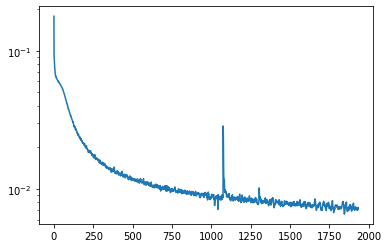

63.47046603984054


In [0]:
# loss = []
# model_reset()
# batch_id = 0
# time_stat = []
while True:
  #if (len(loss) == 500):
  #  opt = tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9)
  #L = learning_step(music_encoded[batch_id:batch_id + 64])
  begin = time.time()
  L, T0, T1 = learning_step_on_compressed_batch(music_compressed[batch_id:batch_id + 64], music_encoded[batch_id:batch_id + 64])
  #print(T0, T1)
  time_stat.append(time.time() - begin)
  if batch_id == 0:
    loss.append(L)
    if len(loss) % 5 == 0:
      np.save('/content/gdrive/My Drive/midi-vae-4-lstm/lstm-2-dir/loss', np.array(loss))
      model.save('/content/gdrive/My Drive/midi-vae-4-lstm/lstm-2-dir/model_{}.h5'.format(len(loss))) #50ms to do
    plt.yscale('log')
    plt.plot(loss[:])
    clear_output(True)
    plt.show()
    print(np.mean(np.array(time_stat)) * (len(music_encoded) // 64))
  
  batch_id += 64
  if batch_id + 64 > len(music_encoded):
    batch_id = 0

In [0]:
def check_song_generation(song_id, show_plots = True, limit = None):
  global test_out_melody
  test_in_melody_encoded = music_encoded[song_id]
  test_out_melody_encoded = np.zeros((200, latent_dim))
  for _ in range(100):
    test_out_melody_encoded[_] = test_in_melody_encoded[_]
  for _ in range(100):
    test_out_melody_encoded[100 + _] = model(test_out_melody_encoded[:100 + _].reshape(1, -1, latent_dim)).numpy()[-1][-1]

  test_out_melody = decoder_model(norm_to_encoded(test_out_melody_encoded)).numpy()
  if show_plots:
    plt.figure(figsize=(30, 3))
    for _ in range(10):
      plt.subplot(1, 10, _ + 1)
      if limit is None:
        plt.imshow(test_out_melody[95 + _].T, cmap='gray')
      else:
        plt.imshow(test_out_melody[95 + _].T > limit, cmap='gray')

  plt.show()

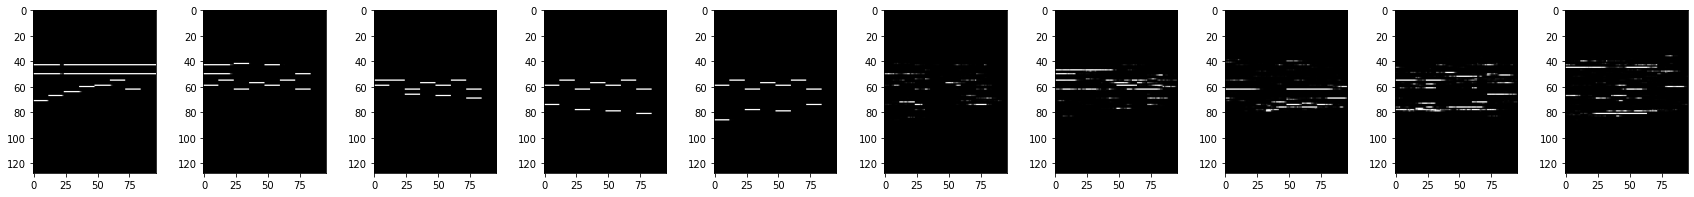

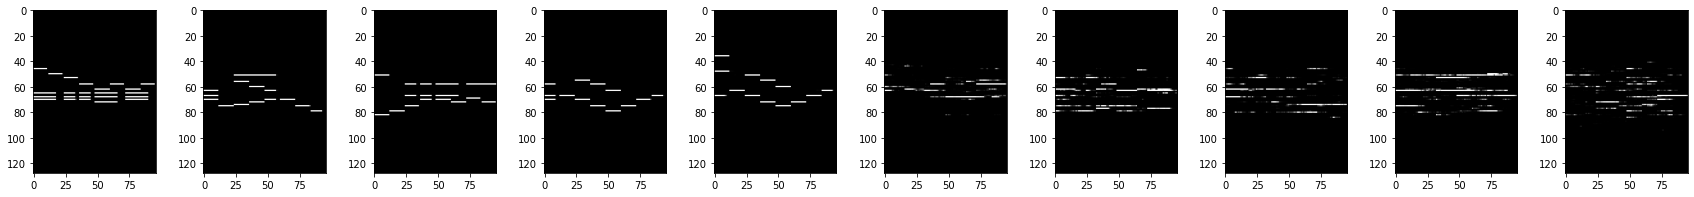

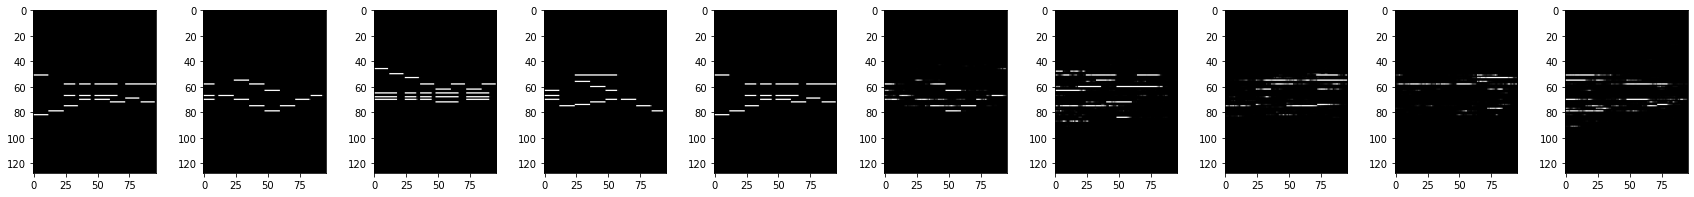

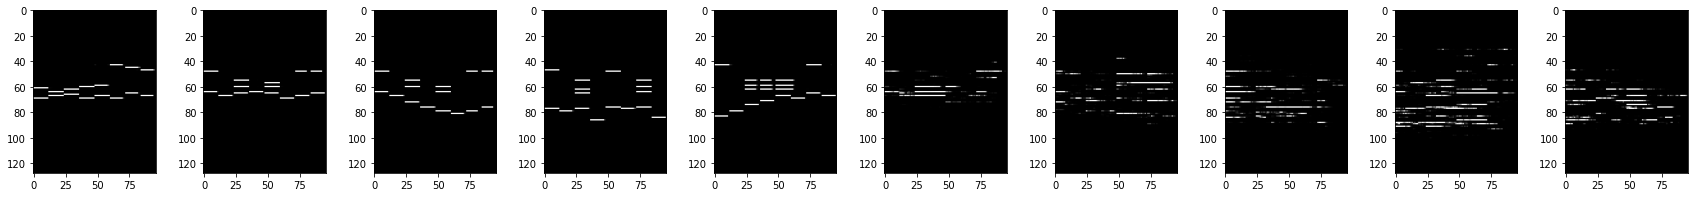

In [0]:
check_song_generation(-1)
check_song_generation(-2)
check_song_generation(-3)
check_song_generation(-4)

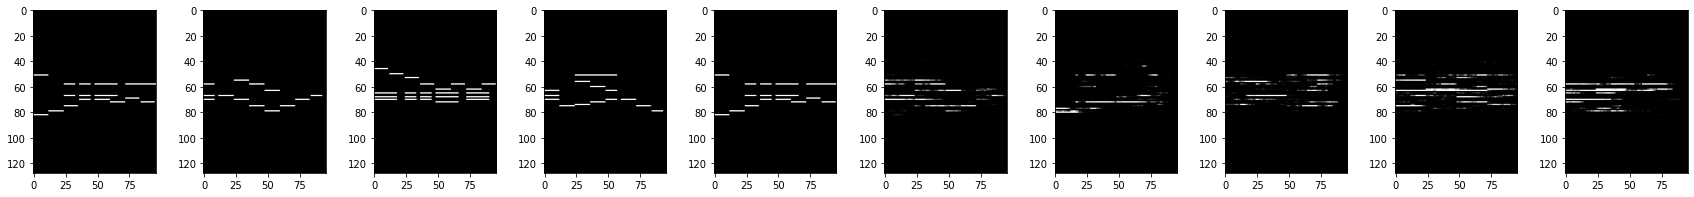

In [0]:
check_song_generation(-3)

In [0]:
!pip install pypianoroll
import pypianoroll as ppr

     |████████████████████████████████| 5.6MB 4.2MB/s 
     |████████████████████████████████| 61kB 9.7MB/s 
  Created wheel for pypianoroll: filename=pypianoroll-0.5.3-cp36-none-any.whl size=23827 sha256=52cdf53c842b09a16167c3dbb519902ae495c094badb579853a7ffb735abd0ae
  Stored in directory: /root/.cache/pip/wheels/29/c8/c0/7b240ab723c2f96b03391796bdf278de513eabf1dfb989c07f
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-cp36-none-any.whl size=5591953 sha256=64571dd8b04123bc66068027398c920377584606d946cf18114c9d57a6a4a400
  Stored in directory: /root/.cache/pip/wheels/4c/a1/c6/b5697841db1112c6e5866d75a6b6bf1bef73b874782556ba66
Successfully built pypianoroll pretty-midi
Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)712704/45929032 bytes (1.6%)

In [0]:
filling_stat = sorted(list(test_out_melody[100:200].reshape(-1)))
filling_input = np.mean(test_out_melody[:100])
limit_output = filling_stat[-int(filling_input * len(filling_stat))]
filling_input = None
filling_stat = None
print(limit_output)

0.96398586


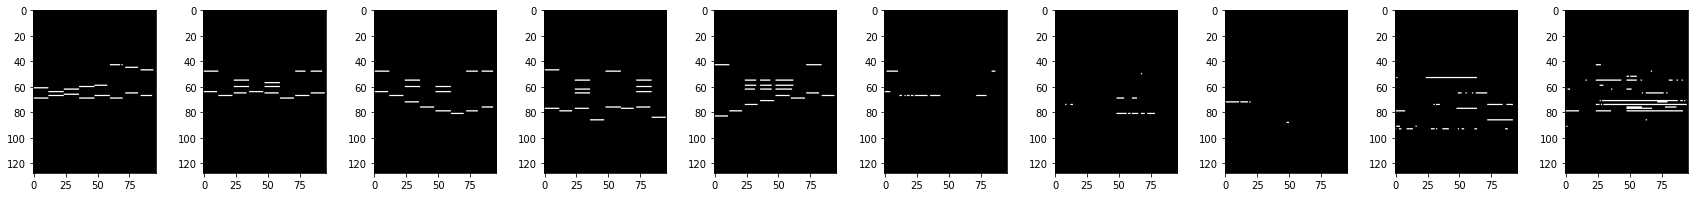

In [0]:
check_song_generation(-4, limit_output)

In [0]:
for _ in tqdm(range(100)):
  check_song_generation(-_, False)
  ppr.Multitrack(tempo=80, tracks=[ppr.Track(pianoroll=(test_out_melody[100:200].reshape(-1, 128)) * 100)]).write('/content/gdrive/My Drive/midi-vae-4-lstm/midi-out/{0}.mid'.format(_))